In this project, we will work with a set of real data published for the shared-task [ProfNER](https://temu.bsc.es/smm4h-spanish/), held in 2021. Specifically, we will use the textual data from subtask 1, which focuses on text classification. This dataset consists of Spanish tweets with a numerical label assigned, representing the presence (value 1) or absence (value 0) of mentions of professions in the tweet. If you are interested, the process of obtaining, selecting, and annotating the data is described [in this link.](https://temu.bsc.es/smm4h-spanish/?p=4003).

For the project, we will train different classification models to correctly classify the tweets. To do this, it will be necessary to create and use data preprocessing functions, apply text embedding vectorization strategies, and train/evaluate classification models.

-	**Exploratory Analysis, Data Preprocessing, and Normalization:**:
        -	The project includes an exploratory analysis of the data, such as the number of documents, distribution graphs of lengths, and word clouds.

    -	It also includes functions for text normalization that allow removing stop words, punctuation symbols, and lemmatization.

-	**Text Vectorization:**

    - As a text vectorization strategy, we use embeddings, taking into account that the embedding should be in Spanish.

-	**Training and Validation of the System**
  -	In the model training process, we test two classification models. First, we estimate the performance of the algorithms in a general way and then select the best one to fine-tune the hyperparameters.


In [2]:
# Data download from ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
!unzip  profner.zip?download=1

--2023-11-08 16:30:08--  https://zenodo.org/record/4563995/files/profner.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.33.206, 188.185.10.78, 188.185.22.33, ...
Connecting to zenodo.org (zenodo.org)|188.185.33.206|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4563995/files/profner.zip [following]
--2023-11-08 16:30:08--  https://zenodo.org/records/4563995/files/profner.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 46552748 (44M) [application/octet-stream]
Saving to: ‘profner.zip?download=1.1’

profner.zip?downloa 100%[===================>]  44.40M  18.7MB/s    in 2.4s    

2023-11-08 16:30:11 (18.7 MB/s) - ‘profner.zip?download=1.1’ saved [46552748/46552748]

Archive:  profner.zip?download=1
replace profner/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Load functions and preparation of the data set.

In [33]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Function to save the content of text files entered into a dictionary.
It returns a dictionary where the keys are the tweet's ID, and the value is the text of the tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()

  return output_dict

def get_profner_data(profner_path_data):
    # Obtain the path to the txt of the tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtain dictionaries where the key is the tweet_id and the value is the text of the tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Load two dataframes with the tweet_id and the category of the tweets.
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Add the text field to the dataframes by mapping the dictionaries using the tweet_id.
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenate the result.
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Remove line breaks.
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

# Project


## 0. Imports


In [4]:
!pip install spacy==3.2.1
!python -m spacy download es_core_news_sm
import nltk
nltk.download('stopwords')

2023-11-08 16:35:25.784515: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 16:35:25.784597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 16:35:25.784682: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 16:35:25.801745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 16:35:27.658458: W tensorflow/compiler/

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()

## 1. Getting the corpus
For obtaining the data, we use the `get_profner_data()` function. This function prepares the data in Pandas dataframe format.

In [6]:
profner_path = "./profner/"
data = get_profner_data(profner_path)

In [7]:
data.head(4)

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train


## 2. Exploratory analysis

We will begin by conducting an analysis of the data before normalizing it. This analysis will allow us to extract relevant information from the dataset and identify potential issues that will be addressed when necessary.

*   **Amount of documents and columns:**



We start by displaying the number of documents, or in other words, the number of rows in the data frame:

In [8]:
print("We have a group of {} documents and the dataframe has {} columns".format(len(data),data.shape[1]))

We have a group of 8000 documents and the dataframe has 4 columns



*   **Amount of duplicate documents:**




Next, we check and remove rows with any empty (NA) values and eliminate duplicates.

In [9]:
print("There are {} duplicated news".format(np.sum(data.duplicated(subset=["tweet_text"]))))
# Removing duplicates
data = data.drop_duplicates()
print("After removing the duplicated we have a group of {} news".format(data.shape[0]))

There are 0 duplicated news
After removing the duplicated we have a group of 8000 news


We will verify that there are no remaining Nulls in either of the two dataset columns.



In [10]:
print("There are {} Null values in the news and {} Null values in the labels of the data".format(np.sum(data.isnull())[0],
                                                                                                        np.sum(data.isnull())[1]))

There are 0 Null values in the news and 0 Null values in the labels of the data



*   **Amount of documents per class:**



We count the number of elements in each class. In the "label" column, we find the dataset labels. In this case, we have two types of documents (tweets):

* "Label = 1": Tweets with a mention of professions in the tweet.
* "Label = 0": Tweets with no mention of professions in the tweet.



Checking the distribution of the labels:

In [11]:
data.groupby(["label"]).count()

,tweet_id,tweet_text,set
label,,,
0,6130,6130,6130
1,1870,1870,1870


Visualization with an histogram

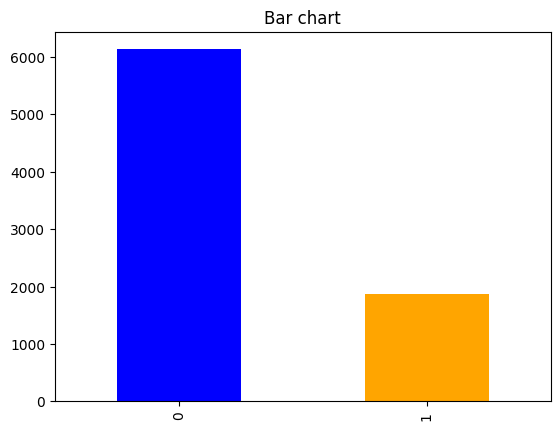

In [12]:
ax, fig = plt.subplots()
labels = data.label.value_counts()
labels.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

We can clearly see that the dataset is not balanced, and we will address this in the following sections.


*   **Tweet content**

Before we begin processing, let's review some tweets from each of the two classes and their respective word clouds.

Tweets with a mention:

In [13]:
data[data.label==1].sample(3).tweet_text.to_list()

['🤔 @Jorgebuxade nos explica la diferencias entre la propuesta de VOX de pagar el sueldo íntegro a los trabajadores y autónomos afectados por el coronavirus y la renta básica socialcomunista.    ✅ Justicia social para los españoles. ❌ #Paguita clientelar y para menas. https://t.co/sGff9DzbgH',
 'Gran noticia! China ha retirado de su lista oficial de "fármacos tradicionales" al pangolín.  Se salvan los pangolines... Y nosotros de una posible futura epidemia. Los científicos habían identificado varios tipos de coronavirus en ellos.  https://t.co/K8Fi4rY4G9',
 'En la Moncloa que murió un trabajador del gobierno de pedro sanchez por el covid, hoy se ha podido ver a Irene Montero sin mascarilla ...  LES da IGUAL-DA todo, https://t.co/N73remcVHp']

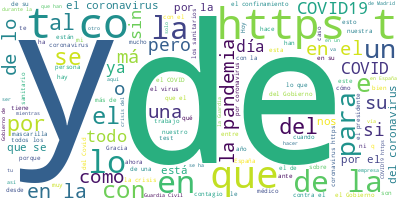

In [14]:
tweet_mention = data[data.label==1].tweet_text.to_list()
# glue the phrases
long_string = ','.join(tweet_mention)
# generates a word cloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
# generates the word cloud
wordcloud.generate(long_string)
wordcloud.to_image()

Tweets without mention:

In [15]:
data[data.label==0].sample(3).tweet_text.to_list()

['Despues de 1500 muertos en Madrid y cuando ha salido la noticia en la prensa,la señora ha considerado que lo mismo era buena idea abrir la UCI que dicen no tener cerrada.Cuando acabe esto,hay que llevar a esta señora al juzgado por negligencia.',
 '¿Por qué se está pidiendo la #RegularizaciónYa ? Escucha al hermano Serigne.  Mañana (18:30) estarán más voces migrantes en el conversatorio q ha organizado la campaña.  Para participar:  1.-Zoom https://t.co/7grMQ4oRsP  2.-Canal youtube #RegularizacionYa: https://t.co/JbdJxeNYFu https://t.co/TpUP2Gidob',
 'Fernando Simón lleva meses trabajando mañana, tarde y noche, de lunes a domingo, con rigor y datos y acudiendo a los mejores expertos del país, contra el coronavirus.  Mientras tanto, la ultraderecha y sus terminales mediáticos llevan meses trabajando contra Fernando Simón. https://t.co/sGUbDVI7ya']

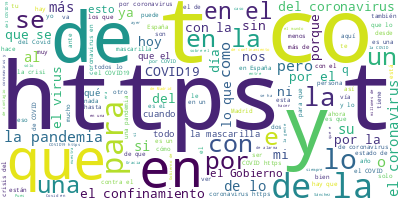

In [16]:
tweet_no_mention = data[data.label==0].tweet_text.to_list()
# glue the phrases
long_string = ','.join(tweet_no_mention)
# generates a word cloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
# generates the word cloud
wordcloud.generate(long_string)
wordcloud.to_image()

As we can see from both word clouds, there is a high presence of stopwords and URLs, which will be addressed in the subsequent sections.


* **Distribution of Tweet Length in Characters:**

To continue with the exploratory analysis, we will perform a common calculation: the length of each text in the documents and then draw its histogram.

We start by creating the columns that will store the length in characters and tokens of the corpus documents:

In [17]:
data["char_len"] = data["tweet_text"].apply(lambda x: len(x))

<ipython-input-18-1d8bdf31b800>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt1 = sns.distplot(data[data.label==0].char_len, hist=True, label="no_mention")
<ipython-input-18-1d8bdf31b800>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt2 = sns.distplot(data[data.label==1].char_len, hist=True, label="mention")


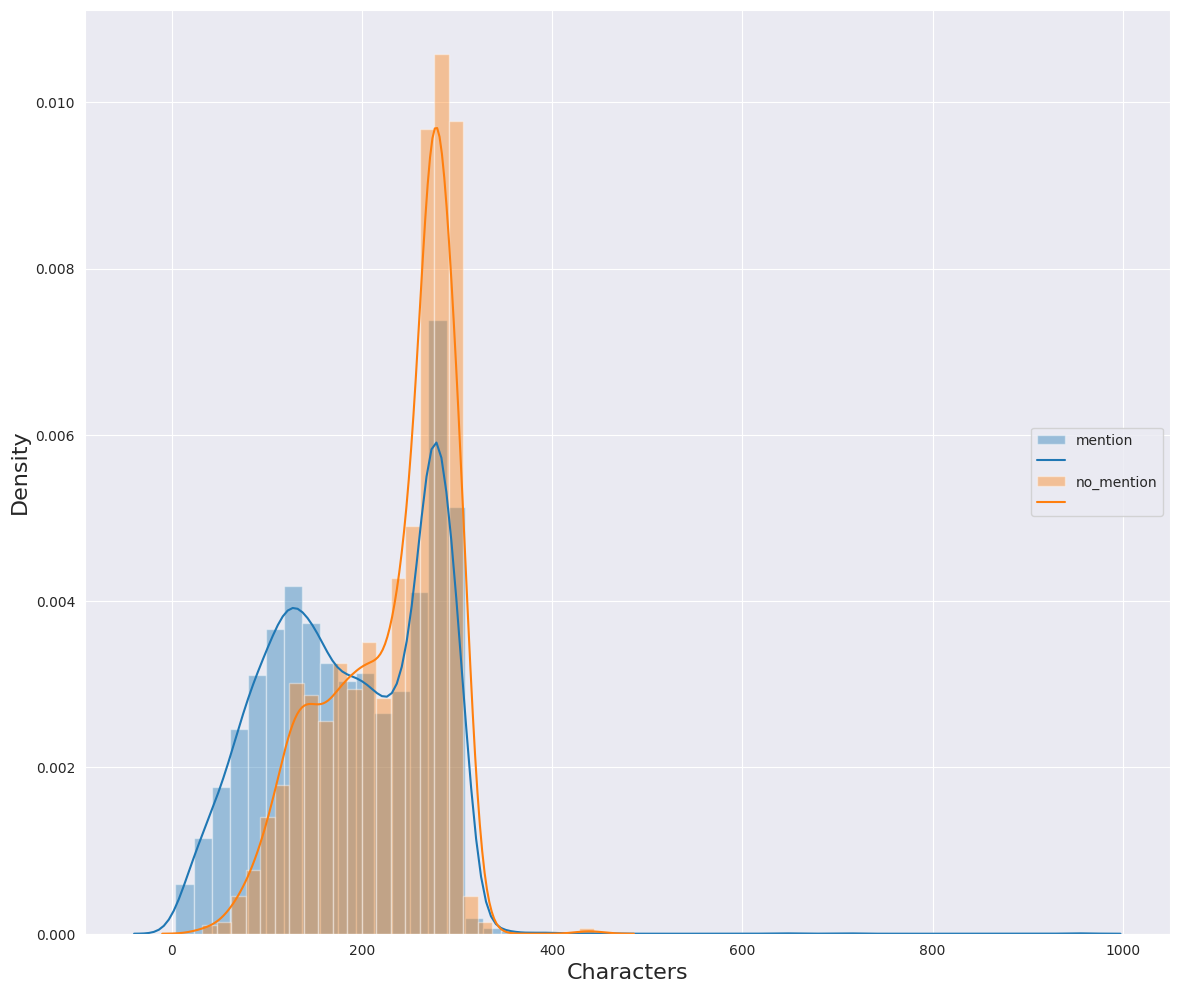

In [18]:
fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
# add a series for each category
plt1 = sns.distplot(data[data.label==0].char_len, hist=True, label="no_mention")
plt2 = sns.distplot(data[data.label==1].char_len, hist=True, label="mention")
plt.legend(labels=['mention',"",'no_mention',""], loc = 5)


# Axis titles
plt.xlabel('Characters', fontsize=16)
plt.ylabel('Density', fontsize=16)

# Show the graph
plt.show()


It can be observed that the density in the tweets with no mentions is slightly higher than those that do mention them.

## 3. Preprocessing and Normalization


We will proceed to normalize the data. To do this, we will use the following functions, which perform the following actions:

* Remove extra spaces
* Convert to lowercase
* Remove emojis since we won't analyze sentiment
* Tokenize
* Remove stop words
* Remove punctuation
* Lemmatize

In [19]:
# Remove extra spaces
def remove_spaces(text):
    return  " ".join(text.split())

# To lower
def texto_to_lower(text):
  return text.lower()

# Remove the emojis from the tweets
def clean_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F300-\U0001F6FF"  # symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u'\u2600-\u26FF\u2700-\u27BF'
        u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C'
        u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
        u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199'
        u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
        u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
        u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
        ']+', flags=re.UNICODE)
    string2 = re.sub(emoji_pattern,r' ',text)
    return string2

# Tokenize the tweets
from nltk.tokenize import TweetTokenizer
def tokenize(text):
  tweet_tokenizer =  TweetTokenizer()
  tokens_list = tweet_tokenizer.tokenize(text)
  return tokens_list

# Remove stop words
from nltk.corpus import stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('spanish'))
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence

# Remove punctuation (keeping only alphanumeric)
def remove_puntuation(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words

# Lemmatization
import spacy
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lemmatization of tokens and converting to lower case
    mytokens = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    return mytokens

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


First, we remove emojis since we won't be analyzing sentiments.

In [20]:
data["tweet_text_processed"] = data["tweet_text"].apply(lambda x: clean_emoji(x))

Then we remove the extra spaces and convert to lower case

In [21]:
data["tweet_text_processed"] = data["tweet_text_processed"].apply(lambda x: remove_spaces(x))
data["tweet_text_processed"] = data["tweet_text_processed"].apply(lambda x: texto_to_lower(x))


Next, we tokenize and process the tokens.

In [22]:
data["tweet_text_tokenize"] = data["tweet_text_processed"].apply(lambda x: tokenize(x))
data["tweet_text_tokenize"] = data["tweet_text_tokenize"].apply(lambda x: remove_stopwords(x))
data["tweet_text_tokenize"] = data["tweet_text_tokenize"].apply(lambda x: remove_puntuation(x))


Finally, we lemmatize.

In [23]:
data["tweet_lematized"] = data["tweet_text_tokenize"].apply(lambda x: lematizar(x))

<ipython-input-24-57020edc410c>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt1 = sns.distplot(data[data.label==0].token_len, hist=True, label="no_mention")
<ipython-input-24-57020edc410c>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt2 = sns.distplot(data[data.label==1].token_len, hist=True, label="mention")

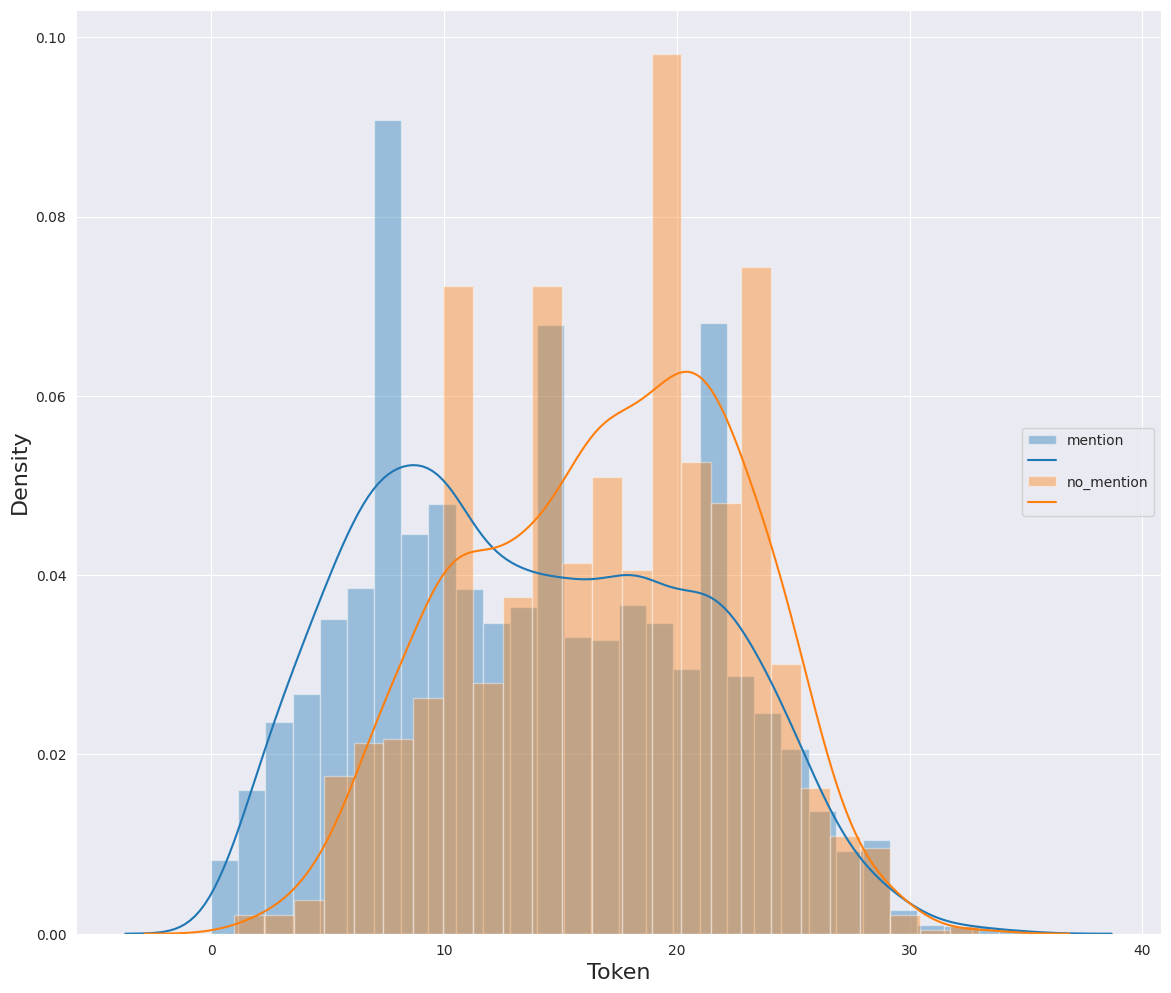

In [24]:
data["token_len"] = data["tweet_lematized"].apply(lambda x: len(x))

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
plt1 = sns.distplot(data[data.label==0].token_len, hist=True, label="no_mention")
plt2 = sns.distplot(data[data.label==1].token_len, hist=True, label="mention")
plt.legend(labels=['mention',"",'no_mention',""], loc = 5)

#  Axis titles
plt.xlabel('Token', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.show()

Comparing this graph with the previous one, it can be observed that data processing has reduced the difference in densities, indicating that both types of tweets do not have significant differences in terms of length.

## 4. Vectorization

Since the text is in the Spanish, we will use the Word2Vec embedding in Spanish.


In [25]:
!wget https://zenodo.org/record/7884437/files/complete.bin.zip?download=1
!unzip /content/complete.bin.zip?download=1

--2023-11-08 16:37:04--  https://zenodo.org/record/7884437/files/complete.bin.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.10.78, 188.185.22.33, 188.185.33.206, ...
Connecting to zenodo.org (zenodo.org)|188.185.10.78|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/7884437/files/complete.bin.zip [following]
--2023-11-08 16:37:05--  https://zenodo.org/records/7884437/files/complete.bin.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 2905851437 (2.7G) [application/octet-stream]
Saving to: ‘complete.bin.zip?download=1.1’

complete.bin.zip?do 100%[===================>]   2.71G  31.6MB/s    in 90s     

2023-11-08 16:38:35 (30.9 MB/s) - ‘complete.bin.zip?download=1.1’ saved [2905851437/2905851437]

Archive:  /content/complete.bin.zip?download=1
replace complete.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

We load the KeyedVectors to save storage space and memory, as it stores them as a dictionary.

In [26]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('complete.bin', binary=True)

We define the function to obtain the vector associated with each document by taking the average of the tokens.

In [27]:
def get_average_vector(sentence):
  list0 = list()
  # Iterate per token
  for i in sentence:
    # Appending each token to a list
    try:
      list0.append(word_vectors.get_vector(i) )
    except:
      continue
    # Compute the mean
  try:
    result = np.mean(list0, axis=0)
  except:
    # If no value is found, we create an array of 0s (the same size as the vector, for Word2Vec in Spanish is 400).
    result = np.zeros(400)
  return result

In [28]:
data["embeddings"] = data["tweet_lematized"].apply(lambda x: get_average_vector(x))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


We generate a new dataframe where the rows represent the number of documents, and the dimensions, in this case, are 400.

In [29]:
vector_data = data.embeddings.apply(pd.Series)

We fill in any empty or NA values that may have appeared in error.






In [30]:
vector_data = vector_data.fillna(0)

We use the scipy library (`sparse.hstack` function) to generate a matrix X that we will use for the subsequent train-test split.

In [31]:
import scipy as sp
# We extract the labels and assign them to the variable 'y'
y = data["label"].values.astype(np.float32)
X = sp.sparse.csc_matrix(vector_data)

####Train/Test division

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)

(6000, 400)
(2000, 400)


####Class Balancing

Due to the imbalance identified in the later parts of this exercise, we will train a simple model to verify that the imbalance does indeed lead to a performance issue.


In [34]:
from imblearn.over_sampling import SMOTE
# Object creation
sm = SMOTE(random_state=42)
# Transformation
X_res, y_res = sm.fit_resample(X_train, y_train)


We observe the result of the balancing:

In [35]:
np.array(np.unique(y_res, return_counts=True)).T

array([[0.000e+00, 4.587e+03],
       [1.000e+00, 4.587e+03]])

## 5. Training and Model Evaluation


**Decision of ML Model**

First, a function has been created to easily measure the quality of various standard models and see their results.

The function performs K-Fold validation and evaluates different models with an evaluation metric.

In [36]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
# Function to evaluate the models
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #For each model
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Generate a KFold
          KF = KFold(n_splits = 8, shuffle = True, random_state = 98)

          # Also cross validation
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Load the results
          results.append(cv_results)
          names.append(name)

          # Showing the results with numbers:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names


Once the function is defined, we can specify the models for evaluation. In this case, logistic regression and Naive Bayes have been included.

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

# Model definition and list with each of them
models = [
         ("Logistic",LogisticRegression()),
         ("GaussianNB",GaussianNB())
]

evaluation_score = "f1"

model_evaluation(models,  evaluation_score, X_res.toarray(), y_res)

Metric: f1 , KFold 
Logistic: 0.831968 (0.010080) 
Metric: f1 , KFold 
GaussianNB: 0.763654 (0.011847) 


([array([0.83737024, 0.83274021, 0.83108108, 0.84568439, 0.81174439,
         0.82136895, 0.83666062, 0.83909014]),
  array([0.73783359, 0.76038339, 0.76510067, 0.76153846, 0.77861446,
         0.77414562, 0.77272727, 0.75888717])],
 ['Logistic', 'GaussianNB'])

We observe better performance with Logistic Regression, so we will try to fine-tune its hyperparameters.

In [61]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear', 'lbfgs']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

We will create a dictionary for the Grid Search and also generate the GridSearchCV object. We will use an f1-based search metric due to the rebalancing.

In [62]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=8)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)

We train the model and print the best result:

In [52]:
grid_result = grid_search.fit(X_res, y_res)
# summarize results
print("Best f1: %f using the parameters %s" % (grid_result.best_score_, grid_result.best_params_))

Best f1: 0.739313 using the parameters {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


Now, we train a specific model:

In [58]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(penalty='l2', C=10.0, solver= 'liblinear')
model.fit(X_res,y_res)


LogisticRegression(C=10.0, solver='liblinear')

We make predictions on our test data and assess the overall performance of the model using a Confusion Matrix and a Classification Report.

In [59]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1248  295]
 [ 106  351]]
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86      1543
         1.0       0.54      0.77      0.64       457

    accuracy                           0.80      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.84      0.80      0.81      2000




Finally, we observe that our precision for the class of interest (1.0) is 0.54 and a f1-score of 0.64.